In [1]:
import gc
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from importlib import reload
from pandas import Timestamp
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator, metocean
map_ = plot.get_map()

In [2]:
plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [3]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

In [4]:
def plot_cone(data, labels, title='', filename=None):
    
    ts = data['reference'].time.values
    lats = data['reference'].latitude.values
    lons = data['reference'].longitude.values
    sim_lats = np.empty((len(ts), len(labels)))
    sim_lons = np.empty((len(ts), len(labels)))

    for i in range(len(ts)):
        t = ts[i]
        for j, label in enumerate(labels):
            dat = data[label]
            sim_lats[i, j] = float(dat['latitude'].interp(time=t, assume_sorted=True).values)
            sim_lons[i, j] = float(dat['longitude'].interp(time=t, assume_sorted=True).values)

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        mean_lats = np.mean(sim_lats, axis=1)
        mean_lons = np.mean(sim_lons, axis=1) 
        
        plt.plot(mean_lons, mean_lats, label='mean')

        std_lats = np.std(sim_lats, axis=1)
        std_lons = np.std(sim_lons, axis=1)
        
        ax = plt.gca()
        
        for j in range(1, 4):
        
            lats_high = []
            lons_high = []
            lats_low = []
            lons_low = []
            
            for i in range(1, len(ts)):

                angle = np.arctan2((mean_lats[i] - mean_lats[i-1]),  (mean_lons[i] - mean_lons[i-1]))
                sigma = j * np.sqrt(std_lats[i]**2 + std_lons[i]**2)
                
                if 90 <= np.rad2deg(angle) <= 180 or -180 <= np.rad2deg(angle) <= -90:
                                    
                    y1 = mean_lats[i] + sigma * np.cos(angle)
                    y2 = mean_lats[i] - sigma * np.cos(angle)
                    x1 = mean_lons[i] - sigma * np.sin(angle)
                    x2 = mean_lons[i] + sigma * np.sin(angle)
                    
                else:
                    
                    y1 = mean_lats[i] + sigma * np.sin(angle)
                    y2 = mean_lats[i] - sigma * np.sin(angle)
                    x1 = mean_lons[i] - sigma * np.cos(angle)
                    x2 = mean_lons[i] + sigma * np.cos(angle)
                    

                if y1 > y2:

                    lats_high.append(y1)
                    lons_high.append(x1)
                    lats_low.append(y2)
                    lons_low.append(x2)

                else:

                    lats_high.append(y2)
                    lons_high.append(x2)
                    lats_low.append(y1)
                    lons_low.append(x1)

            lats_high = np.array(lats_high)
            lons_high = np.array(lons_high)
            lats_low = np.array(lats_low)
            lons_low = np.array(lons_low)

            lons_ = np.append(np.vstack((lons_low, lons_high[::-1])).ravel(), mean_lons[0])
            lats_ = np.append(np.vstack((lats_low, lats_high[::-1])).ravel(), mean_lats[0])
            
            polygon_xys = np.column_stack((lons_, lats_))
            polygon = Polygon(polygon_xys, fill=True, alpha=0.2, label=fr'$\sigma_{j}$')
            ax.add_patch(polygon)

    ax.scatter(lons, lats, color='k')
    ax.set_aspect('equal', adjustable='box')   
    plt.legend()
    plt.title('\n'.join(wrap(title)))
    plt.xticks([])
    plt.yticks([])
    
    if filename:
        fig = plt.gcf()
        fig.savefig(filename, bbox_inches='tight')


In [5]:
beacon_id = '90679'

df = sd.get_beacon_df(beacon_id=beacon_id)

start_time = df.DataDate_UTC.values[809] # note index 809 is where the hourly averaging starts
end_time = start_time + np.timedelta64(1, 'D')

tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

ref_lats, ref_lons = tc.ref_lats.values, tc.ref_lons.values
ref_xs, ref_ys = map_(ref_lons, ref_lats)
ref_xs /= 1000
ref_ys /= 1000
ref_x0 = ref_xs[0]
ref_y0 = ref_ys[0]
ref_xs -= ref_xs[0]
ref_ys -= ref_ys[0]

# Plot 1 - Observed Drift Track Segment

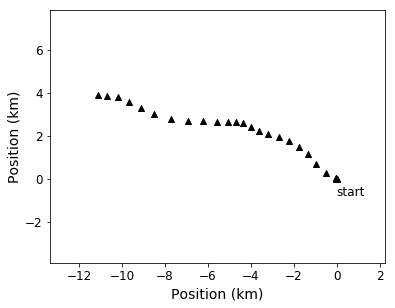

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.margins(x=0.2, y=1)
ax.scatter(ref_xs, ref_ys, marker='^', c='black')
ax.annotate(xy=(ref_xs[0], ref_ys[0]), s='start', xytext=(0, -0.8),)
ax.set_xlabel('Position (km)')
ax.set_ylabel('Position (km)')
plt.show()

# Plot 2 - Metocean Panels

In [7]:
ocean = metocean.Ocean((start_time, end_time))
atm = metocean.Atmosphere((start_time, end_time))

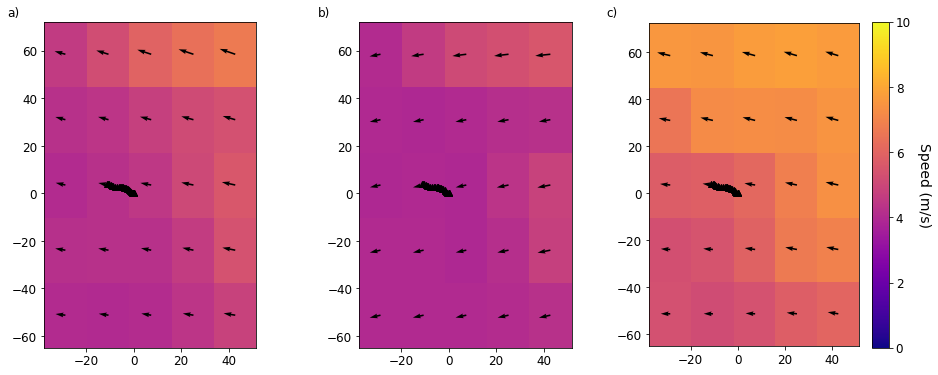

In [8]:
llcrnrlon = -52
llcrnrlat = 51
urcrnrlon = -51
urcrnrlat = 52

# field =ocean.data
# lons = field.longitude.values
# lats = field.latitude.values
# times = field.time.values
# velocity_field = ocean.current
# cbar_label = 'Current speed (m/s)'
# cmap = 'viridis'
# vmin = 0
# vmax = 0.5

field = atm.data
lons = field.longitude.values
lats = field.latitude.values - 0.125
times = field.time.values
velocity_field = atm.wind
cbar_label = 'Wind speed (m/s)'
cmap = 'plasma'
vmin = 0
vmax = 10

lons = field.longitude.values
lats = field.latitude.values - 0.125
times = field.time.values
x_indices = np.where((lons >= llcrnrlon) & (lons <= urcrnrlon))[0]
x_index_0, x_index_n = x_indices[0], x_indices[-1]
y_indices = np.where((lats >= llcrnrlat) & (lats <= urcrnrlat))[0]
y_index_0, y_index_n = y_indices[0], y_indices[-1]
t_indices = np.where((times >= tc.start_time) & (times <= tc.end_time))[0]
t_index_0, t_index_n = t_indices[0], t_indices[-1]
lons = lons[x_index_0 : x_index_n + 1]
lats = lats[y_index_0 : y_index_n + 1]
times = times[t_index_0 : t_index_n + 1]


us_0 = velocity_field.eastward_velocities.values[0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us_12 = velocity_field.eastward_velocities.values[3, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
us_24 = velocity_field.eastward_velocities.values[-1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

vs_0 = velocity_field.northward_velocities.values[0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs_12 = velocity_field.northward_velocities.values[3, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
vs_24 = velocity_field.northward_velocities.values[-1, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

xs_, ys_ = map_(lons, lats)
xs = (xs_ / 1000) - ref_x0
ys = (ys_ / 1000) - ref_y0

xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
xxs, yys = np.meshgrid(xs_1, ys_1)

fig = plt.figure(figsize=(16, 6))
fig.tight_layout()

ax1 = fig.add_subplot(131, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_0**2 + vs_0**2), cmap=cmap, vmin=vmin, vmax=vmax)
plt.quiver(xs, ys, us_0, vs_0, units='xy', angles='xy')
plt.scatter(ref_xs, ref_ys, color='black', marker='^')
plt.figtext(0.12, 0.9,'a)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)


ax2 = fig.add_subplot(132, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_12**2 + vs_12**2), cmap=cmap, vmin=vmin, vmax=vmax)
plt.quiver(xs, ys, us_12, vs_12, units='xy', angles='xy')
plt.scatter(ref_xs, ref_ys, color='black', marker='^')
plt.figtext(0.39, 0.9,'b)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

ax3 = fig.add_subplot(133, aspect='equal')
plt.pcolor(xxs, yys, np.sqrt(us_24**2 + vs_24**2), cmap=cmap, vmin=vmin, vmax=vmax)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('Speed (m/s)', rotation=270)

plt.quiver(xs, ys, us_24, vs_24, units='xy', angles='xy')
plt.scatter(ref_xs, ref_ys, color='black', marker='^')
plt.figtext(0.64, 0.9,'c)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

plt.show()

# Plot 3 - Ensemble from Optimizing Ca and Cw

In [9]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc
sim.results.map = map_

In [10]:
ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = None, None
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

n = 6
N = n**2

err_dict = {'Ca': np.zeros(N), 'Cw': np.zeros(N), 'err': np.zeros(N)}

Cas = np.linspace(0.1, 4, n)
Cws = np.linspace(0.1, 4, n)
Ca_mesh, Cw_mesh = np.meshgrid(Cas, Cws)
Cas = Ca_mesh.flatten()
Cws = Cw_mesh.flatten()

sim.results.add_xy_to_existing_dataset('reference')

for i in range(N):                

    label = str(i)
    Ca = Cas[i]
    Cw = Cws[i]
    run_sim_kwargs['Ca'] = Ca
    run_sim_kwargs['Cw'] = Cw
    sim.run_simulation(label=label, **run_sim_kwargs)
    sim.results.add_xy_to_existing_dataset(label)
    xs = sim.results.data[label]['easting']
    ys = sim.results.data[label]['northing']
    ref_xs_ = sim.results.data['reference']['easting']
    ref_ys_ = sim.results.data['reference']['northing']
    err = calc_mean_error((ys, xs), (ref_ys_, ref_xs_))
    err_dict['Ca'][i] = Ca
    err_dict['Cw'][i] = Cw
    err_dict['err'][i] = err


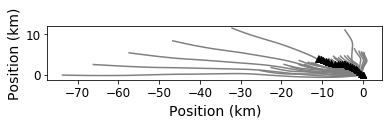

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

labels = [str(i) for i in range(N)]

for label in labels:

    sim.results.add_xy_to_existing_dataset(label)
    xs = sim.results.data[label]['easting'].values - ref_x0
    ys = sim.results.data[label]['northing'].values - ref_y0
    ax.plot(xs, ys, color='grey')
    
ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

ax.set_xlabel('Position (km)')
ax.set_ylabel('Position (km)')

plt.show()

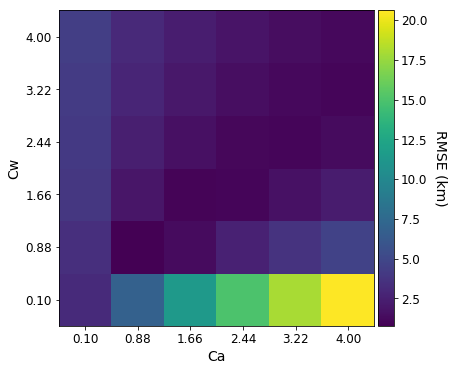

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Cas = Cws = np.linspace(0.1, 4, n)
Cas = np.append(Cas, Cas[-1] + np.mean(np.diff(Cas)))
Cws = np.append(Cws, Cws[-1] + np.mean(np.diff(Cws)))

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

plt.pcolor(Cas - np.mean(np.diff(Cas)) / 2, Cws - np.mean(np.diff(Cws)) / 2 , err_dict['err'].reshape(6, 6))

ax.set_xticks(Cas[:-1])
ax.set_yticks(Cws[:-1])

plt.xlabel('Ca')
plt.ylabel('Cw')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('RMSE (km)', rotation=270)

plt.show()

# Plot 4 - Optimized Track

In [13]:
labels = []
index = np.argmin(err_dict['err'][:])
min_err = err_dict['err'][index]
optimal_Ca = err_dict['Ca'][index]
optimal_Cw = err_dict['Cw'][index]
print('err: {}, Ca: {}, Cw: {}'.format(min_err, optimal_Ca, optimal_Cw))
labels.append(f'{index}')
labels += ['reference']


err: 0.783017282739785, Ca: 0.88, Cw: 0.88


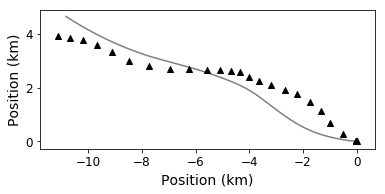

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
    
label = labels[0]

xs = sim.results.data[label]['easting'].values - ref_x0
ys = sim.results.data[label]['northing'].values - ref_y0
ax.plot(xs, ys, color='grey')
    
ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

ax.set_xlabel('Position (km)')
ax.set_ylabel('Position (km)')

plt.show()

In [15]:
labels = [str(i) for i in range(N)]
for label in labels:
    sim.results.remove_dataset(label)

# Plot 5 - Ensemble Spaghetti

In [16]:
Ca, Cw = optimal_Ca, optimal_Cw
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

num_start_times = 1

N = 10

for i in range(N):

    sim.run_simulation(label=f'{i}', **run_sim_kwargs)

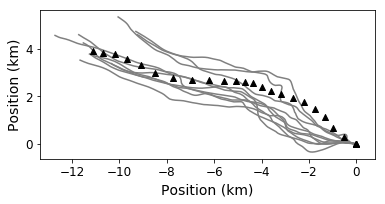

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
    
labels = [str(i) for i in range(N)]

for label in labels:

    sim.results.add_xy_to_existing_dataset(label)
    xs = sim.results.data[label]['easting'].values - ref_x0
    ys = sim.results.data[label]['northing'].values - ref_y0
    ax.plot(xs, ys, color='grey')
    
ax.scatter(ref_xs, ref_ys, color='black', marker='^', zorder=1000)

ax.set_xlabel('Position (km)')
ax.set_ylabel('Position (km)')

plt.show()

# Plot 6 - Cones 

In [18]:
rd = sim.results.data

In [19]:
labels = list(rd.keys())

x_data = []
y_data = []

for i, label in enumerate(labels):
    if not label == 'reference':
        x_data.append(rd[label]['easting'].values - ref_x0)
        y_data.append(rd[label]['northing'].values - ref_y0)

x_data = np.array(x_data)
y_data = np.array(y_data)

r = 0.5
dx = 0.05
dy = 0.05

X, Y = np.mgrid[-15:2:dx, -2:8:dy]
Z = np.zeros_like(X, dtype='int')

for x, y in zip(x_data, y_data):
    Z_ = np.zeros_like(Z)
    for x_, y_ in zip(x, y):
        Z_[np.sqrt((X+dx/2-x_)**2 + (Y+dy/2-y_)**2) < r] = 1
    Z += Z_
    
# divide by the realizations to come up with a probability
m = len(labels) - 1
Z = Z / m

In [20]:
def plot_probabilistic_map(XYZ, xys, ref_xys=None, cbar_step=0.1):
    
    X, Y, Z = XYZ
    x_data, y_data = xys
    ref_x, ref_y  = ref_xys
    
    n_levels = np.arange(0, 1 + cbar_step, cbar_step)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, aspect='equal')
    
    if ref_xys:
        plt.scatter(ref_x, ref_y, color='black', zorder=1000, label='observed')
    
    plt.contourf(X, Y, Z, n_levels, alpha=0.7)

    plt.plot(x_data.T, y_data.T, 'k-',  alpha=0.2, linewidth=1.5)
    plt.plot(np.mean(x_data, 0), np.mean(y_data, 0), 'k-', linewidth=2, label='mean')
      
    plt.legend()

    plt.xlabel('Position (km)')
    plt.ylabel('Position (km)')
    plt.title('Probability contour map of location of iceberg')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    
    plt.show()

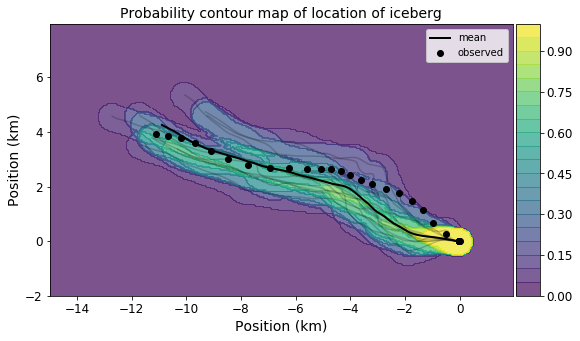

In [21]:
plot_probabilistic_map((X, Y, Z), (x_data, y_data), (ref_xs, ref_ys), 0.05)